# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [1]:
# %pip install --force-reinstall -v "qiskit==1.4.2"
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install qiskit_algorithms --upgrade
# %pip install pylatexenc --upgrade

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'1.4.2'

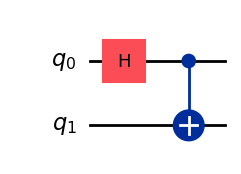

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [4]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [5]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        ,  0.00390625,  0.00390625,  1.        , -0.0234375 ,
       -0.0234375 ]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0044534, 'sample_measure_time': 0.0008144, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999847412109375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0044534, 'sample_measure_time': 0.0008

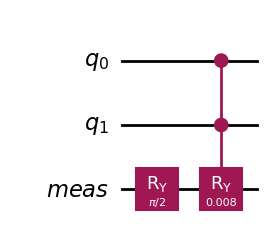

In [6]:
from qiskit import QuantumRegister
from qiskit.circuit.library import RYGate

def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    qc.ry(np.pi / 2, meas[0])                    # RY(π/2) on |0> → |+_y>
    return meas

def apply_excess_rotations_demo(qc: QuantumCircuit,
                                loss_reg: QuantumRegister,
                                flag_qubit,
                                meas_qubit,
                                c: float = 1e-2):
    """
    Implements θ = π/4 + 0.4 c (x‑1) on `meas_qubit`
    using a *pair of controls*  (flag == 1  AND  bit_i == 1).

    Parameters
    ----------
    loss_reg    : QuantumRegister
        Holds  x-1  (n qubits after the subtractor).
    flag_qubit  : Qubit
        Set to 1 exactly when the loss is above the deductible.
    meas_qubit  : Qubit
        The qubit prepared by `add_measure_qubit_and_bias`.
    c           : float
        Small scale factor in the paper (default 1e‑2).
    """
    n = len(loss_reg)
    base = 0.8 * c

    for i, bit in enumerate(loss_reg):
        weight   = 1 << i                        # 2**i
        angle    = base * weight                 # Δθ contribution of this bit
        ry_gate  = RYGate(angle)
        ccry     = ry_gate.control(2)            # 2‑controlled RY
        # controls:  flag , loss_reg[i]   – target: meas_qubit
        qc.append(ccry, [flag_qubit, bit, meas_qubit])

qc = QuantumCircuit(2)

loss_reg = qc.qubits[0:1] # 1) Loss register (2 qubits)
flag_q = qc.qubits[1] # 1) Flag qubit

# 2) Measurement qubit
meas_reg = add_measure_qubit_and_bias(qc)        # returns a QuantumRegister(1)
meas_q = meas_reg[0]

# 3) Controlled rotations
apply_excess_rotations_demo(qc,
                            loss_reg=loss_reg,
                            flag_qubit=flag_q,
                            meas_qubit=meas_q,
                            c=1e-2)                   # choose c small (paper says “small number”)

qc.draw(output='mpl')

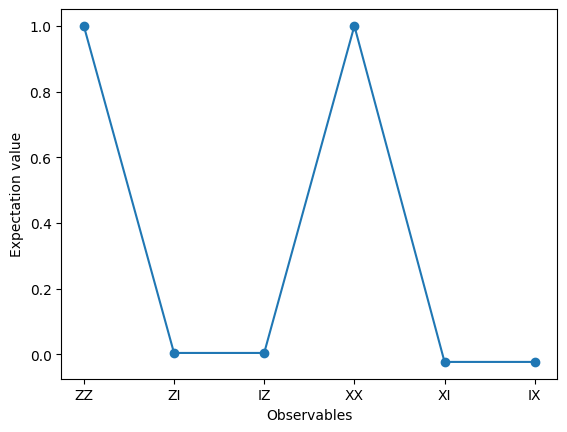

In [7]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 4  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10
deductible = 1.0  # Deductible amount

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals = np.linspace(
    domain_min + step / 2,
    domain_max - step / 2,
    N
)
probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
probabilities /= probabilities.sum()

# Full distribution for visualization
full_sims = 10_000
full_x_vals = np.linspace(domain_min, domain_max, full_sims)
full_step = (domain_max - domain_min) / (full_sims - 1)
full_mid_vals = np.linspace(
    domain_min + full_step / 2,
    domain_max - full_step / 2,
    full_sims
)
full_probabilities = np.array([lognormal_loss(x) * full_step for x in full_mid_vals])
full_probabilities /= full_probabilities.sum()

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
# qc.draw(output='mpl')

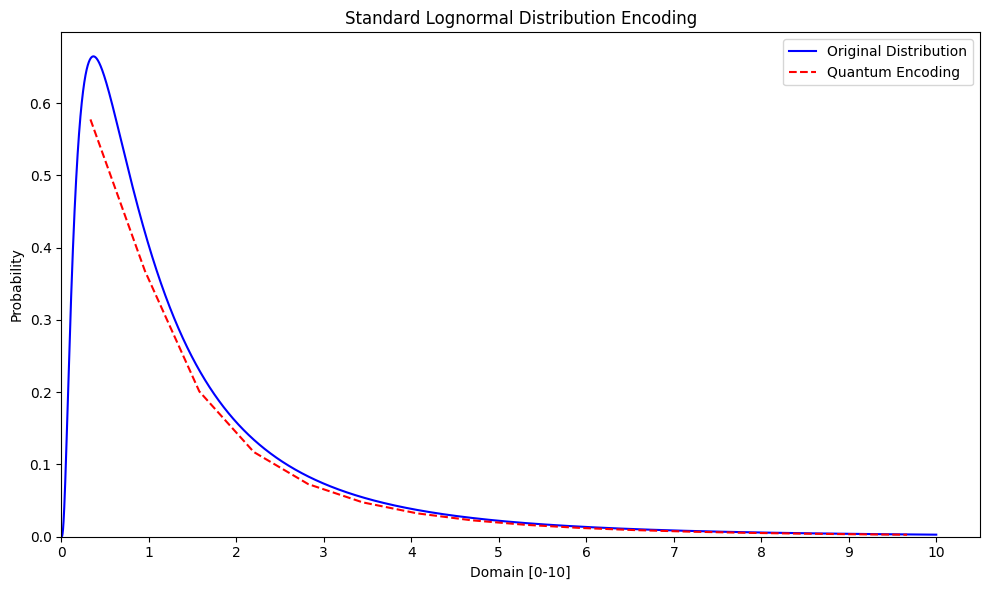

In [9]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Plot State Degeneration With Decreased Qubits

C:\Users\alexf\AppData\Local\Temp\ipykernel_69296\149723388.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)


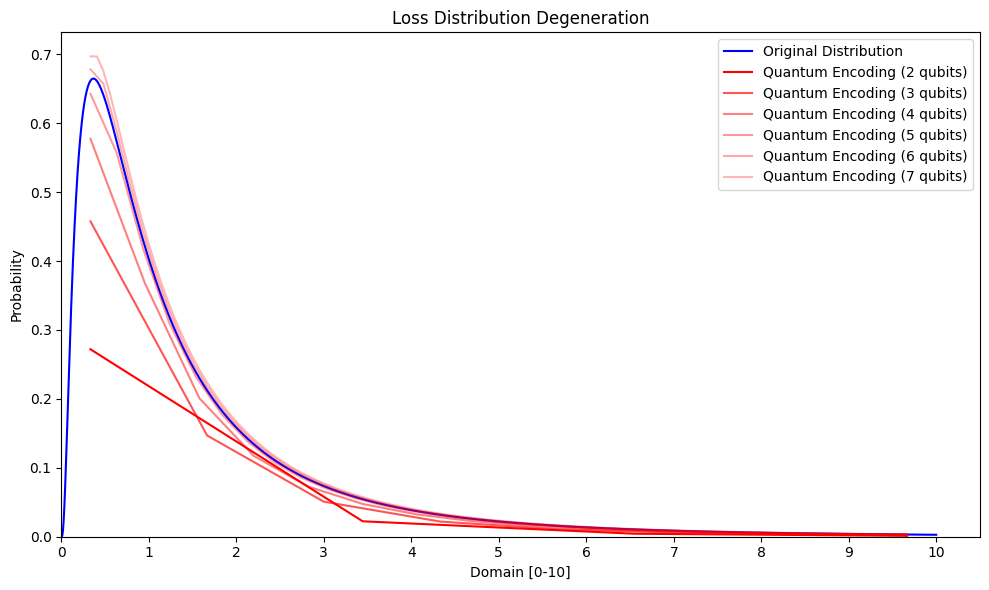

In [10]:
num_qubits_list = range(2, 8)
N_list = [2**n for n in num_qubits_list]
step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for N in N_list]
probabilities_list = []
for i, N in enumerate(N_list):
    x_vals = mid_x_vals_list[i]
    step = step_list[i]
    probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
    probabilities /= probabilities.sum()
    probabilities_list.append(probabilities)

# Add Color
cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
for i, N in enumerate(num_qubits_list):
    x_vals = mid_x_vals_list[i]
    step = step_list[i]
    probabilities = probabilities_list[i]
    alpha = 1/(i/2 + 1)
    plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Loss Distribution Degeneration')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

## Implement Quantum Subtraction

In [ ]:
# index of the first grid‑point *above* the deductible
step         = (domain_max - domain_min) / (N - 1)
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

# def reverse_bits(k: int, n: int) -> int:
#     """
#     Fix qubit reference since IBM is little-endian (in fact that doesn't seem to be the case).
#     Reverse the bits of `k` in a binary representation of length `n`.
#     """
#     b = f"{k:0{n}b}"
#     return int(b[::-1], 2)

# threshold_rev = reverse_bits(threshold_idx, num_qubits)
# print(f"little-endian binary threshold = {threshold_rev:0{num_qubits}b}")

threshold = 2
binary threshold = 0010
little-endian binary threshold = 0100


### Build the Excess Circuit

In [12]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.arithmetic import CDKMRippleCarryAdder
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.circuit import Qubit

def subtract_if_excess(num_qubits: int, threshold: int) -> QuantumCircuit:
    """
    Works on Qiskit 2.x where AddConstant is gone.
    If x >= threshold set flag=1 and compute x <- x - threshold (mod 2**num_qubits)
    else set flag=0 and leave x unchanged.

    Note: The threshold must be little-endian binary.
    """
    # allow threshold accidentally passed as a Qubit
    if isinstance(threshold, Qubit):
        threshold = threshold.index
    threshold = int(threshold)

    # Create Registers
    x_reg   = QuantumRegister(num_qubits, "x") # loss amount
    const   = QuantumRegister(num_qubits, "c") # holds (2ⁿ - k)
    flag    = QuantumRegister(1, "flag")  # comparison result
    w_cmp   = QuantumRegister(num_qubits - 1, "w_cmp") # ancillas comparator
    carry   = QuantumRegister(1, "carry") # carry qubit for the adder
    circuit = QuantumCircuit(x_reg, const, flag, w_cmp, carry, name="Sub>k")

    # Prepare |2ⁿ - k>  once in the const register
    delta = (-threshold) % (1 << num_qubits) # 2's‑complement of k
    for i in range(num_qubits):
        if (delta >> i) & 1:
            circuit.x(const[i])

    # 1) Compare x with k → flag
    compare_gate = IntegerComparator(num_state_qubits=num_qubits, value=threshold, geq=True)
    circuit.append(compare_gate,  x_reg[:] + flag[:] + w_cmp[:])

    # 2) Controlled addition: x ← x + delta  (≡ x − k mod 2ⁿ)
    #     The CDKM adder writes the sum into the *second* operand,
    #     so we order the qubits as (const, x).
    #     Since const is classical‑data only, it is unchanged and can be reused.
    adder = CDKMRippleCarryAdder(num_qubits, kind="fixed").control()
    circuit.append(adder,  flag[:] + const[:] + x_reg[:] + carry[:])

    # 3) Un‑compute comparator ancillas so only FLAG stores the outcome
    circuit.append(compare_gate.inverse(),  x_reg[:] + flag[:] + w_cmp[:])

    circuit.x(flag[0])

    # # Clear circuit name to prevent unknown subcircuit name issues
    # circuit.name = ""
    return circuit

In [13]:
# state‑preparation circuit `qc` you already built
loss_reg = qc.qregs[0]                # |ψ₁⟩, 6 qubits

# allocate once
flag  = QuantumRegister(1, "flag")
const = QuantumRegister(num_qubits, "const")
work  = QuantumRegister(num_qubits - 1, "w_cmp")
carry = QuantumRegister(1, "carry")
qc.add_register(flag, const, work, carry)

In [14]:

sub_block = subtract_if_excess(num_qubits, threshold_idx)
qc.append(sub_block, loss_reg[:] + const[:] + flag[:] + work[:] + carry[:])
qc.barrier()
# qc.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=13, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(4, 'const'), 0), Qubit(QuantumRegister(4, 'const'), 1), Qubit(QuantumRegister(4, 'const'), 2), Qubit(QuantumRegister(4, 'const'), 3), Qubit(QuantumRegister(3, 'w_cmp'), 0), Qubit(QuantumRegister(3, 'w_cmp'), 1), Qubit(QuantumRegister(3, 'w_cmp'), 2), Qubit(QuantumRegister(1, 'carry'), 0)), clbits=())

In [15]:
from qiskit.quantum_info import Statevector

# Simulate the circuit to get the statevector
sv = Statevector.from_instruction(qc)

In [16]:
# marginal probability of flag==1 must equal P[x ≥ deductible]
# index of the single‑qubit flag register inside *this* circuit
flag_index = qc.qubits.index(flag[0])

p_excess = sv.probabilities_dict(qargs=[flag_index])['1']
print(f"P(loss ≥ 1) = {p_excess:.4f}")

P(loss ≥ 1) = 0.7878


In [17]:
# probabilities from state-prep
p_classical = probabilities[threshold_idx:].sum()
print(f"classical P(X ≥ 1) = {p_classical:.6f}")

classical P(X ≥ 1) = 0.890244


## Controlled Rotations

In [18]:
from qiskit.circuit.library import RYGate

def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    qc.ry(np.pi / 2, meas[0])                    # RY(π/2) on |0> → |+_y>
    return meas

def apply_excess_rotations(qc: QuantumCircuit,
                            loss_reg: QuantumRegister,
                            flag_qubit,
                            meas_qubit,
                            step,
                            c: float = 1e-2):
    """
    Implements θ = π/4 + 0.4 c (x‑1) on `meas_qubit`
    using a *pair of controls*  (flag == 1  AND  bit_i == 1).

    Parameters
    ----------
    loss_reg    : QuantumRegister
        Holds  x-1  (n qubits after the subtractor).
    flag_qubit  : Qubit
        Set to 1 exactly when the loss is above the deductible.
    meas_qubit  : Qubit
        The qubit prepared by `add_measure_qubit_and_bias`.
    c           : float
        Small scale factor in the paper (default 1e‑2).
    """
    n = len(loss_reg)
    base = 0.8 * c * step

    for i, bit in enumerate(loss_reg):
        weight   = 1 << i                        # 2**i
        angle    = base * weight                 # Δθ contribution of this bit
        ry_gate  = RYGate(angle)
        ccry     = ry_gate.control(2)            # 2‑controlled RY
        # controls:  flag , loss_reg[i]   – target: meas_qubit
        qc.append(ccry, [flag_qubit, bit, meas_qubit])

In [19]:
# 1) Our circuit so far
# qc  –  contains:  • loss register  (called loss_reg or qc.qregs[0])
#                   • flag qubit    (the output of subtract_if_excess)

loss_reg = qc.qregs[0]             # 6 qubits
flag_q = qc.qubits[loss_reg.size]

# 2) Measurement qubit
meas_reg = add_measure_qubit_and_bias(qc)        # returns a QuantumRegister(1)
meas_q = meas_reg[0]

# 3) Controlled rotations
apply_excess_rotations(qc,
                        loss_reg=loss_reg,
                        flag_qubit=flag_q,
                        meas_qubit=meas_q,
                        step=step,
                        c=1e-2)                   # choose c small (paper says “small number”)

qc.barrier(label="controlled RY block")
# qc.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=14, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(4, 'const'), 0), Qubit(QuantumRegister(4, 'const'), 1), Qubit(QuantumRegister(4, 'const'), 2), Qubit(QuantumRegister(4, 'const'), 3), Qubit(QuantumRegister(3, 'w_cmp'), 0), Qubit(QuantumRegister(3, 'w_cmp'), 1), Qubit(QuantumRegister(3, 'w_cmp'), 2), Qubit(QuantumRegister(1, 'carry'), 0), Qubit(QuantumRegister(1, 'meas'), 0)), clbits=())

## Measure Expectation from State Vector

In [20]:
from qiskit.quantum_info import Statevector, partial_trace

# names below follow the helpers we built earlier
loss_reg  = qc.qregs[0]
flag_q    = flag_index
meas_q    = qc.qubits.index(qc.qregs[-1][0]) # last qubit added by add_measure_qubit_and_bias
c_param   = 1e-2                             # <-- keep in sync with apply_excess_rotations
coins     = 0.4                              # 40 % share in the paper

def expected_payment_exact(circ: QuantumCircuit,
                            meas_idx: int,
                            c: float,
                            coins: float = 0.4) -> float:
    """Directly compute E[payout] from the final state‑vector."""
    sv  = Statevector.from_instruction(circ)

    # Trace out all qubits except the measurement qubit
    rho_meas = partial_trace(sv, [q for q in range(circ.num_qubits) if q != meas_idx])
    p1       = np.real(rho_meas.data[1, 1])          # probability of |1>

    excess   = (p1 - 0.5) / (coins * c)              # E[(X-1)^+]
    return coins * excess

In [21]:
pay_exact = expected_payment_exact(qc, meas_q, c_param, coins)
print(f"Exact (state‑vector)  E[payment] = {pay_exact:.8f}")

Exact (state‑vector)  E[payment] = 0.62130178


In [22]:
e_pmt_qubits_2 = 0.00000000
e_pmt_qubits_3 = 0.00000000
e_pmt_qubits_4 = 0.05210658
e_pmt_qubits_5 = 0.13722302
e_pmt_qubits_6 = 0.36249506
e_pmt_qubits_7 = 0.85405207
e_pmt_qubits_8 = None
e_pmt_qubits_9 = None
e_pmt_qubits_10 = None

## Convergence Study

In [23]:
from qiskit_aer import Aer
from qiskit import ClassicalRegister, transpile

def convergence_study(circ,
                    meas_idx,
                    c_param,
                    coins=0.4,
                    shot_grid=(100, 500, 1_000, 5_000, 10_000, 50_000, 100_000),
                    seed=1234):
    """Return a DataFrame with estimates vs. shots and draw a log‑x plot."""

    backend = Aer.get_backend("qasm_simulator")

    # helper: single‑shot Monte‑Carlo estimator
    def _estimate(shots):
        qc_samp = circ.copy()
        creg    = ClassicalRegister(1, 'c')
        qc_samp.add_register(creg)
        qc_samp.measure(qc_samp.qubits[meas_idx], creg[0])

        counts = backend.run(transpile(qc_samp, backend),
                            shots=shots, seed_simulator=seed).result().get_counts()
        p1      = counts.get('1', 0) / shots
        excess  = (p1 - 0.5) / (coins * c_param)
        return coins * excess

    # run for each shot count
    estimates = [_estimate(s) for s in shot_grid]
    df = pd.DataFrame({"shots": shot_grid, "expected_payment": estimates})

    # --- visualise --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(df["shots"], df["expected_payment"], "-o")
    plt.xscale("log")
    plt.xlabel("shots (log scale)")
    plt.ylabel("expected reinsurer payment")
    plt.title("Monte‑Carlo convergence")
    plt.grid(True, which="both", ls="--")
    plt.show()

    return df

In [24]:
# df_conv = convergence_study(qc,
#                             meas_idx=meas_q,
#                             c_param=c_param,
#                             coins=coins,
#                             shot_grid=np.linspace(100, 100_000, 100))
# # Save for later comparison, if you like
# df_conv.to_csv("mc_convergence.csv", index=False)
# df_conv

In [25]:
from qiskit.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

sampler = Sampler()                                   # AerSampler by default
problem = EstimationProblem(
    state_preparation = qc,
    objective_qubits  = [meas_q]
)

iae = IterativeAmplitudeEstimation(
        epsilon_target = 0.01,        # desired abs‑err on amplitude
        alpha          = 0.05,        # 95 % confidence
        sampler        = sampler)

result = iae.estimate(problem)
p1     = result.estimation
calls  = result.num_oracle_queries

excess   = (p1 - 0.5) / (0.4 * c_param)
payment  = 0.4 * excess
print(f"AE payout ≈ {payment:.6f}  (oracle calls = {calls})")

C:\Users\alexf\AppData\Local\Temp\ipykernel_69296\659920527.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()                                   # AerSampler by default


AE payout ≈ 0.621302  (oracle calls = 0)


In [26]:
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

def expected_payment_via_iqae_legacy(circ: QuantumCircuit,
                                    meas_idx: int,
                                    c: float,
                                    coins: float = 0.4,
                                    epsilon: float = 2e-3,
                                    alpha: float   = 0.05):
    """Iterative AE using the pre‑primitive API (compatible with Qiskit 1.4.x)."""
    sampler = StatevectorSampler()
    problem = EstimationProblem(
        state_preparation = circ,
        objective_qubits  = [meas_idx]
    )

    iae = IterativeAmplitudeEstimation(
            epsilon_target = epsilon,
            alpha          = alpha,
            sampler        = sampler)

    result = iae.estimate(problem)
    p1     = result.estimation
    calls  = result.num_oracle_queries
    excess   = (p1 - 0.5) / (0.4 * c_param)
    payment  = 0.4 * excess
    return payment, result.num_oracle_queries

pay_iqae, calls = expected_payment_via_iqae_legacy(qc, meas_q, c_param, coins,
                                                    epsilon=2e-3, alpha=0.05)
print(f"IQAE (legacy)        E[payment] = {pay_iqae:.8f} (oracle calls = {calls})")

KeyError: 0

In [ ]:
epsilons = [0.2, 0.1, 0.05, 0.02, 0.01]
oracle_calls = []

for eps in epsilons:
    pay, calls = expected_payment_via_iqae_legacy(
        qc, meas_q, c_param, coins,
        epsilon=eps, alpha=0.05
    )
    oracle_calls.append(calls)

import pandas as pd
df = pd.DataFrame({"epsilon": epsilons, "oracle_calls": oracle_calls})
print(df)

C:\Users\alexf\AppData\Local\Temp\ipykernel_101752\3621755724.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()                                   # AerSampler by default


   epsilon  oracle_calls
0     0.20             0
1     0.10             0
2     0.05             0
3     0.02             0
4     0.01             0


Plot oracle_calls vs 1/epsilon on a log‑log scale—you’ll see a straight line with slope ≈ 1, confirming the 1/ε behaviour.

## Classical Monte Carlo

In [ ]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(sigma, loc=0, scale=np.exp(mu))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - 0.6*(lnorm - 1) - 1
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - 0.6*(lnorm_0_10 - 1) - 1
    cmc_results_0_10[i] = payout_0_10


C:\Users\alexf\AppData\Local\Temp\ipykernel_101752\1067880937.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


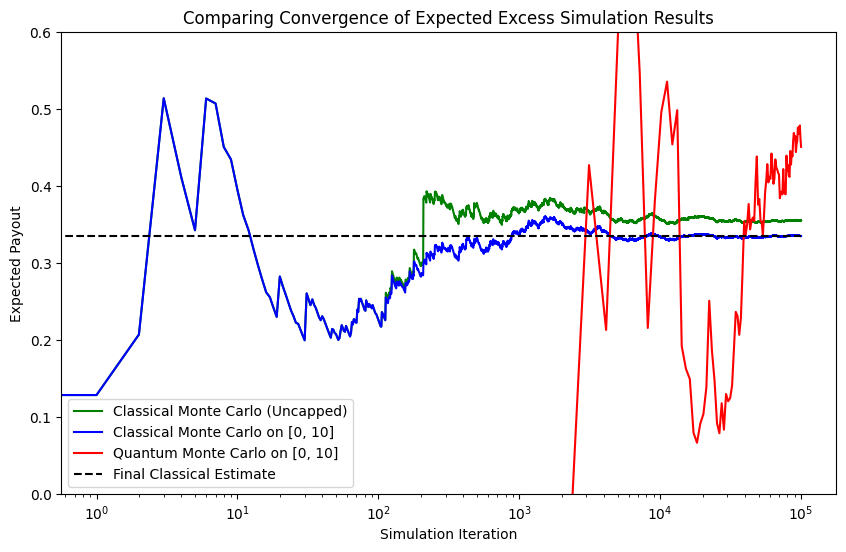

In [ ]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Final Classical Estimate')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 0.6)
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

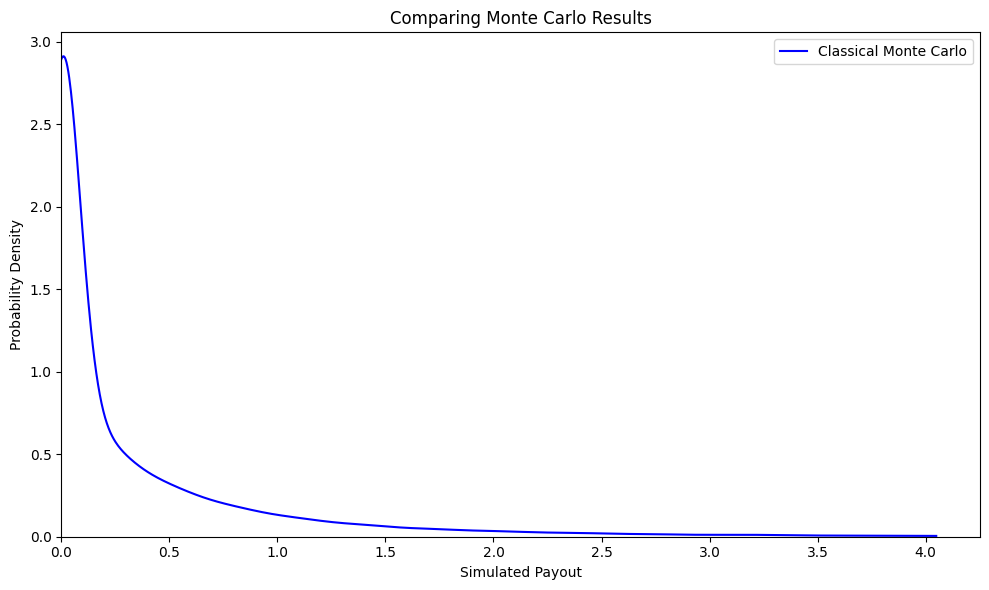

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()